In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/chexnet_sgd.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/val'

SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

#### Keras Callbacks

In [3]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(chexnet_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(chexnet_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=15,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 9130 images belonging to 3 classes.
Found 2032 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.972310969116081, 1: 1.0144444444444445, 2: 1.0144444444444445}
samples for train class labels: dict_items([(0, 3130), (1, 3000), (2, 3000)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 923), (1, 800), (2, 309)])


### ChexNet Model Compile

In [5]:
CHEXNET_WEIGHTS_PATH ='/home/ChexNet/pretrained/chexnet-pretrained-weights.h5'
base_model = DenseNet121(weights=None,include_top=False,input_shape=INPUT_SHAPE)
out = Dense(14, activation='sigmoid')(base_model.output)
base_model = Model(inputs=base_model.input, outputs=out) 
base_model.load_weights(CHEXNET_WEIGHTS_PATH)

for layer in base_model.layers:
    layer.trainable=True

chexnet_extract = base_model.layers[-2].output
chexnet_extract = GlobalAveragePooling2D()(chexnet_extract)
chexnet_extract = tf.keras.layers.BatchNormalization()(chexnet_extract)
output = Dense(3, activation='softmax')(chexnet_extract)

chexnet_model = Model(base_model.input, output)
chexnet_model.summary()

2022-08-14 04:26:22.853582: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-14 04:26:22.853665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5808 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [6]:
sgd = SGD(learning_rate=1e-3, momentum = 0.9, nesterov = True)
chexnet_model.compile(
    optimizer=sgd,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [7]:
history = chexnet_model.fit(train_generator,
                            epochs=20,
                            validation_data=validation_generator,
                            verbose=1,
                            class_weight = class_weights,
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  0.001
Epoch 1/20


2022-08-14 04:26:50.358568: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


286/286 [==============================] - ETA: 0s - loss: 0.5726 - accuracy: 0.7766 - AUC: 0.9152 - precision: 0.8193 - recall: 0.7192
Epoch 00001: val_loss improved from inf to 0.76120, saving model to ./weights/chexnet_sgd.hdf5
End of epoch 0. Learning rate: 0.001
286/286 [==============================] - 134s 418ms/step - loss: 0.5726 - accuracy: 0.7766 - AUC: 0.9152 - precision: 0.8193 - recall: 0.7192 - val_loss: 0.7612 - val_accuracy: 0.6949 - val_AUC: 0.8423 - val_precision: 0.7296 - val_recall: 0.5974 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
286/286 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.8459 - AUC: 0.9546 - precision: 0.8660 - recall: 0.8256
Epoch 00002: val_loss did not improve from 0.76120
End of epoch 1. Learning rate: 0.001
286/286 [==============================] - 117s 407ms/step - loss: 0.4153 - accuracy: 0.8459 - AUC: 0.9546 - precision: 0.8660 - recall: 0.8256 - val_loss: 0.9169 - val_accuracy: 0.6334 - val_AUC: 0.8084 - val_pre

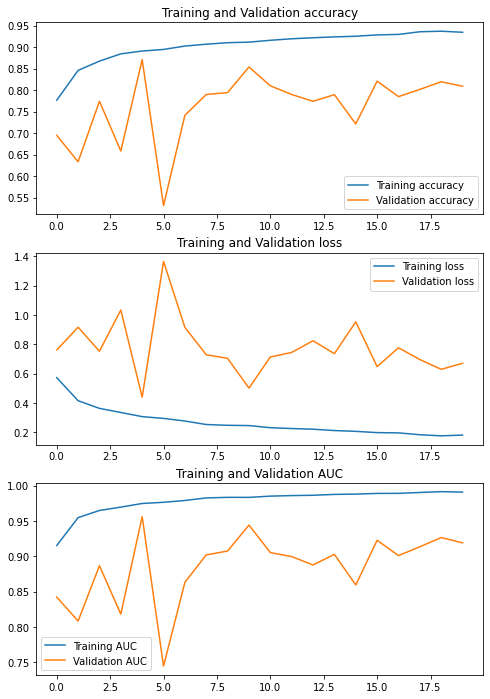

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_accuracy'],ascending=False)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
4,0.306495,0.890909,0.974591,0.901115,0.876342,0.439332,0.871063,0.956007,0.873569,0.863681,0.001
9,0.245636,0.911610,0.983230,0.920058,0.903834,0.501405,0.853839,0.944044,0.858917,0.850886,0.001
15,0.197492,0.928368,0.988814,0.933954,0.923111,0.648050,0.820866,0.922563,0.825161,0.819882,0.001
18,0.175442,0.937021,0.991313,0.942702,0.931654,0.629388,0.819390,0.926494,0.822685,0.817421,0.001
10,0.230944,0.915882,0.984994,0.924226,0.908434,0.713526,0.810039,0.905204,0.811601,0.805610,0.001
19,0.180741,0.934502,0.990700,0.938925,0.929463,0.670575,0.809055,0.918910,0.810464,0.808071,0.001
17,0.183041,0.935706,0.990149,0.941528,0.931216,0.696167,0.801673,0.913347,0.805748,0.800197,0.001
8,0.247341,0.910296,0.983289,0.917709,0.900219,0.704225,0.794291,0.907381,0.798307,0.788878,0.001
7,0.252767,0.906791,0.982467,0.915710,0.899562,0.728864,0.789862,0.901874,0.797990,0.781496,0.001


#### Fine-tune ChexNet

In [10]:
# Get number of layers in the base_model
print("Number of layers in the base model: ", len(base_model.layers))
for layer in base_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

chexnet_model.summary()

Number of layers in the base model:  428
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                   

In [11]:
sgd = SGD(learning_rate=1e-4, momentum = 0.9, nesterov = True)
chexnet_model.compile(
    optimizer=sgd,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.Precision(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [12]:
history_finetune = chexnet_model.fit(train_generator,
                            epochs=40,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 20/40
286/286 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9364 - AUC: 0.9416 - precision: 0.9416 - recall: 0.9323
Epoch 00020: val_loss did not improve from 0.43933
End of epoch 19. Learning rate: 1e-04
286/286 [==============================] - 130s 423ms/step - loss: 0.1774 - accuracy: 0.9364 - AUC: 0.9416 - precision: 0.9416 - recall: 0.9323 - val_loss: 0.7182 - val_accuracy: 0.7943 - val_AUC: 0.7962 - val_precision: 0.7962 - val_recall: 0.7923 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 21/40
286/286 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9402 - AUC: 0.9463 - precision: 0.9463 - recall: 0.9355
Epoch 00021: val_loss did not improve from 0.43933
End of epoch 20. Learning rate: 1e-04
286/286 [==============================] - 121s 422ms/step - loss: 0.1654 - accuracy: 0.9402 - AUC: 0.9463 - precision: 0.9463 - recall: 0.9355 - val_loss: 0.7073 - val_accuracy: 0.7982 - val_AUC: 

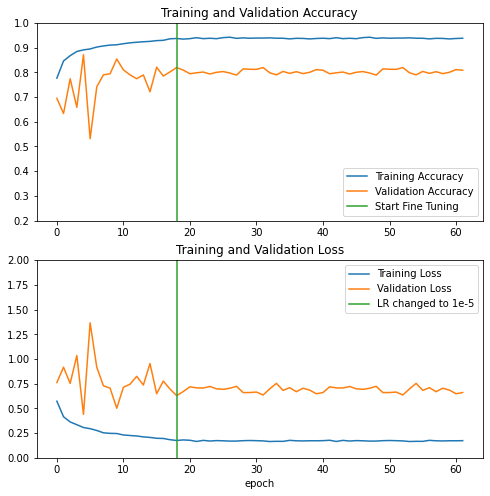

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='LR changed to 1e-5')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_accuracy'],ascending=False)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
11,0.170893,0.938664,0.943687,0.943687,0.932421,0.635585,0.819390,0.822013,0.822013,0.815945,0.0001
8,0.173279,0.939430,0.945091,0.945091,0.933187,0.660002,0.813976,0.817146,0.817146,0.811516,0.0001
9,0.174932,0.938007,0.944198,0.944198,0.934064,0.660264,0.812500,0.815385,0.815385,0.808563,0.0001
10,0.173266,0.938773,0.942898,0.942898,0.935049,0.665243,0.812008,0.814172,0.814172,0.808563,0.0001
19,0.172203,0.937021,0.940481,0.940481,0.932859,0.648041,0.811024,0.814392,0.814392,0.807579,0.0001
20,0.173460,0.938007,0.943565,0.943565,0.933954,0.660144,0.808563,0.810891,0.810891,0.806102,0.0001
14,0.166305,0.937897,0.942889,0.942889,0.933078,0.682084,0.803642,0.806739,0.806739,0.801181,0.0001
5,0.172066,0.940526,0.944457,0.944457,0.936802,0.692941,0.803150,0.806436,0.806436,0.801673,0.0001
16,0.171989,0.937678,0.942367,0.942367,0.933078,0.668554,0.802657,0.806244,0.806244,0.800689,0.0001


### Model Evaluation

In [21]:
TEST_IMAGE_FOLDER = '/home/TBX11K/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = chexnet_model.predict(test_generator)

Found 69 images belonging to 3 classes.


In [22]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.05      0.10        40
           2       0.43      1.00      0.60        29

    accuracy                           0.45        69
   macro avg       0.72      0.53      0.35        69
weighted avg       0.76      0.45      0.31        69

